# Base Model Componenets


## Imports

In [ ]:
!pip install torchvision
from torchvision import datasets
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.cluster import normalized_mutual_info_score

ERROR: Operation cancelled by user


## Function to show images



In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


## Function to regenerate an image from a given image

In [ ]:
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size))
    except:
        out, _, _ = model(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)


## Function to generate an image from an arbitary distribution.

In [ ]:
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

## Configuretions



In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Dataset Loading

In [ ]:
# Specify data directory
data_dir = 'data'

# Fashion-MNIST dataset
dataset  = datasets.FashionMNIST(root=data_dir, train=True, download=True,
                                  transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root=data_dir, train=False, download=True,
                                  transform=transforms.ToTensor())

# Data loaders (adjust batch size as needed)
data_loader  = torch.utils.data.DataLoader(dataset=dataset , batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)

# Now you have access to the Fashion-MNIST dataset through train_loader and test_loader

## VAE Architecture

In [ ]:

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


## Create VAE model

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train the model

In [ ]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 426.8288, KL Div: 10.3158
Epoch[1/15], Step [20/469], Reconst Loss: 384.1685, KL Div: 8.3051
Epoch[1/15], Step [30/469], Reconst Loss: 339.1738, KL Div: 11.0594
Epoch[1/15], Step [40/469], Reconst Loss: 313.7850, KL Div: 12.9478
Epoch[1/15], Step [50/469], Reconst Loss: 310.8654, KL Div: 12.4377
Epoch[1/15], Step [60/469], Reconst Loss: 303.8616, KL Div: 11.1346
Epoch[1/15], Step [70/469], Reconst Loss: 286.6503, KL Div: 14.3321
Epoch[1/15], Step [80/469], Reconst Loss: 291.1757, KL Div: 13.1839
Epoch[1/15], Step [90/469], Reconst Loss: 285.7676, KL Div: 13.2056
Epoch[1/15], Step [100/469], Reconst Loss: 291.3252, KL Div: 13.7319
Epoch[1/15], Step [110/469], Reconst Loss: 275.8967, KL Div: 15.1469
Epoch[1/15], Step [120/469], Reconst Loss: 278.0534, KL Div: 14.7988
Epoch[1/15], Step [130/469], Reconst Loss: 268.3159, KL Div: 14.4292
Epoch[1/15], Step [140/469], Reconst Loss: 263.4751, KL Div: 15.0223
Epoch[1/15], Step [150/469], Reconst Loss: 2

## Show generation

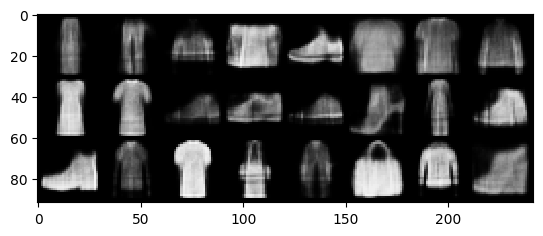

In [ ]:
plot_generation(model)

## Show Reconstraction

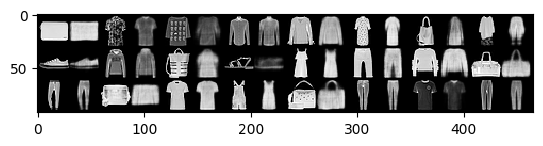

In [ ]:
plot_reconstruction(model)

# Tasks

## a.
### Change the base three layer model into a four layer model

In this task you need to modify the VAE class and convert it into a four layer class

In [ ]:
# Change the VAE class

In [ ]:
# Create new model

In [ ]:
# Train new model

In [ ]:
# Compare the final loss of the fully trained old model and the new model

In [ ]:
# Compare the reconstructed images from the two models

In [ ]:
# Compare generate images from the two models

## b.
### Change the layers

In this experiment you will change the layers of the VAE using different combinations and compare the results

In [ ]:
# Create different 3 layer VAE models with different h-dim and z-dim

In [ ]:
# Train all models

In [ ]:
# Compare the models based on their optimal loss

In [ ]:
# Compare models based on their generated images (visual inspection)

In [ ]:
# Compare models based on their regenerated images (visual inspection)

## c.
### Create a Normal Autoencoder

In this experiment you will convert the current model into an autoencoder

In [ ]:
# Convert the VAE class into an 3layer autoencoder

In [ ]:
# Create the autoenocder model

In [ ]:
# Change the training procedure to train the auto-enocder

In [ ]:
# Compare the models based on their optimal loss

In [ ]:
# Compare models based on their generated images (visual inspection)

In [ ]:
# Compare models based on their regenerated images (visual inspection)

## References
1. https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb